In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from ydata_profiling import ProfileReport

In [2]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
import geopandas as gpd

import folium 
from folium import plugins
from folium.plugins import HeatMap

import geopy.geocoders
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Bing

import reverse_geocoder as rg

In [4]:
df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/train_cleaned.csv')

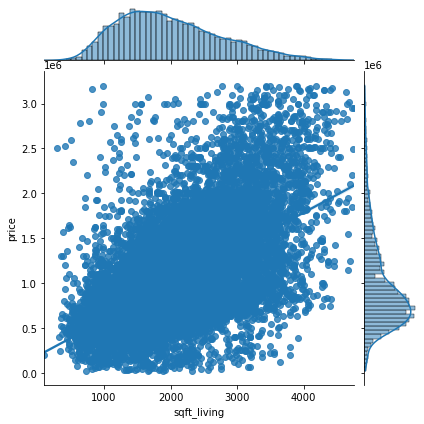

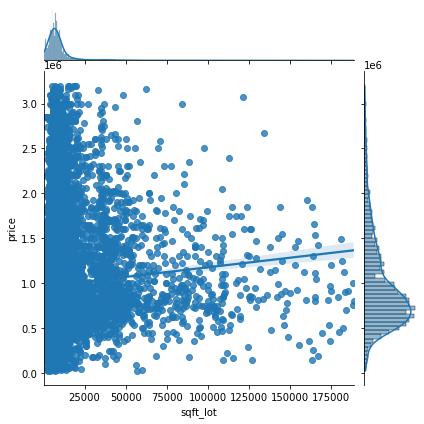

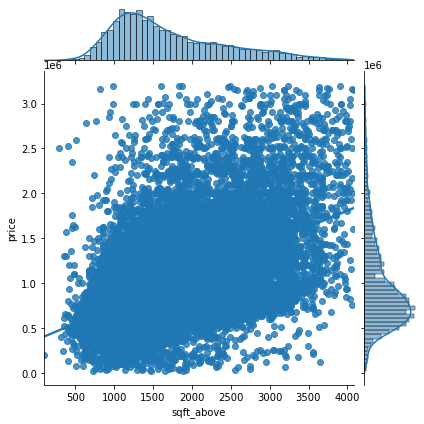

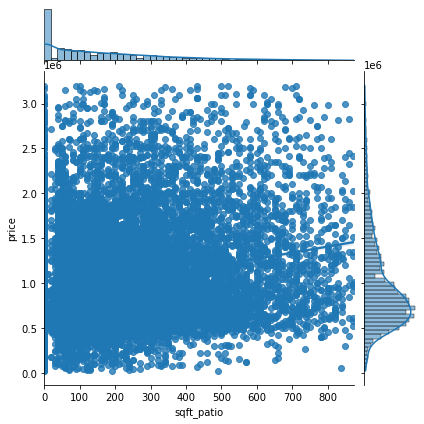

In [5]:
# We want to look at linearity of some select features vs our target variable, price
cont_feat = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_patio']


#  Plot jointplots
for feature in cont_feat:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

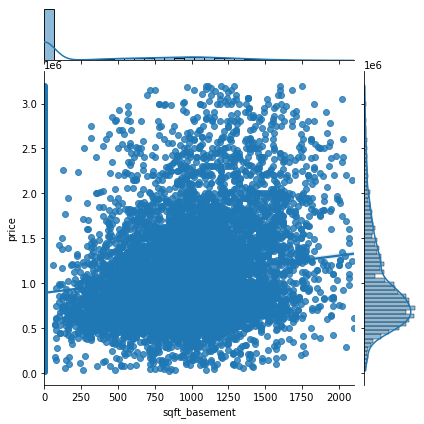

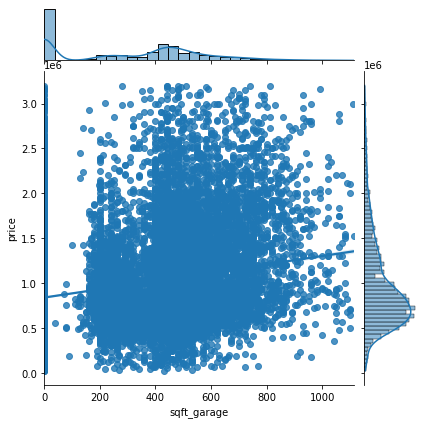

In [6]:
# let's look at linearity for some different continuous features

cont_feat_2 = ['sqft_basement', 'sqft_garage']


#  Plot jointplots
for feature in cont_feat_2:
    sns.jointplot(x = df[feature], y = df['price'], kind = 'reg')

In [7]:
# we're getting really screwed up data due to the zeroes in the basement sq foot. we are unsure whether to leave this
# column and calculate its mean, or create a new column of the mean with just those places that have a basement

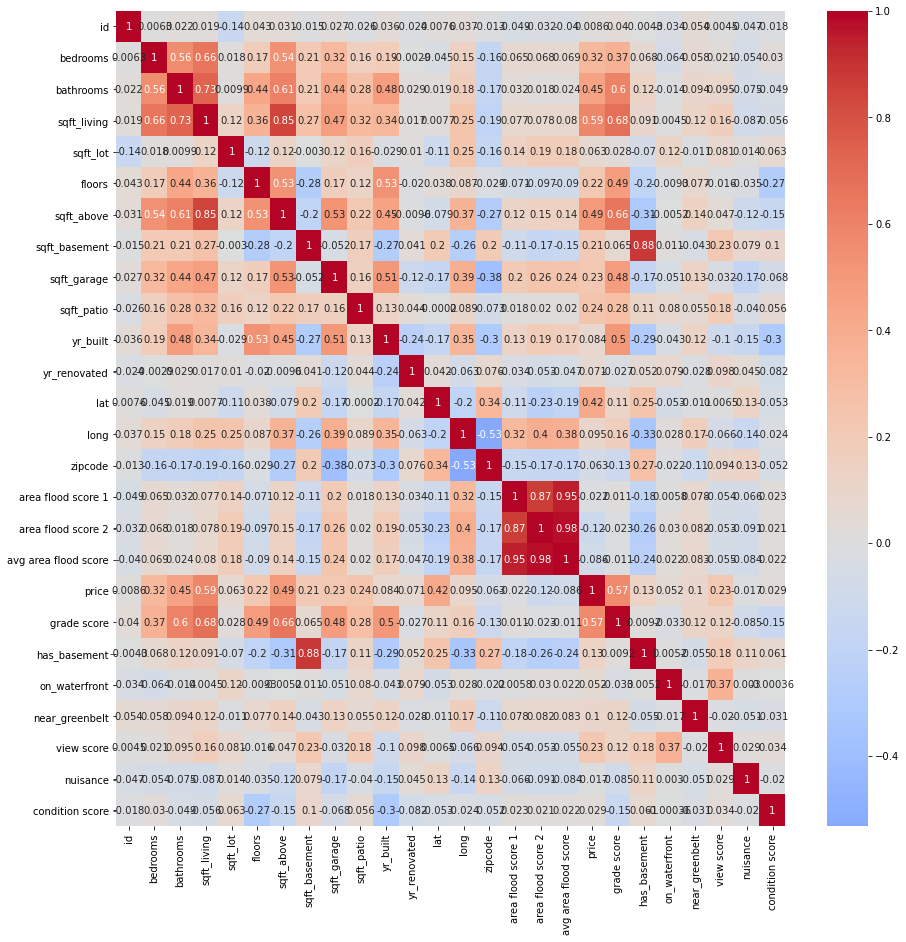

In [8]:
# done with continuous variables, so let's look again at multicollinearity using heatmaps

corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [9]:
# gonna drop sq_basement, since it is so highly correlated with "has_basement" AND so few have basements that it
# really skews the mean

In [10]:
df.drop(labels='sqft_basement', axis=1, inplace=True)

In [11]:
# sqft_above is also fairly strongly correlated AND isn't super-relevant for our purposes
df.drop(labels='sqft_above', axis=1, inplace=True)

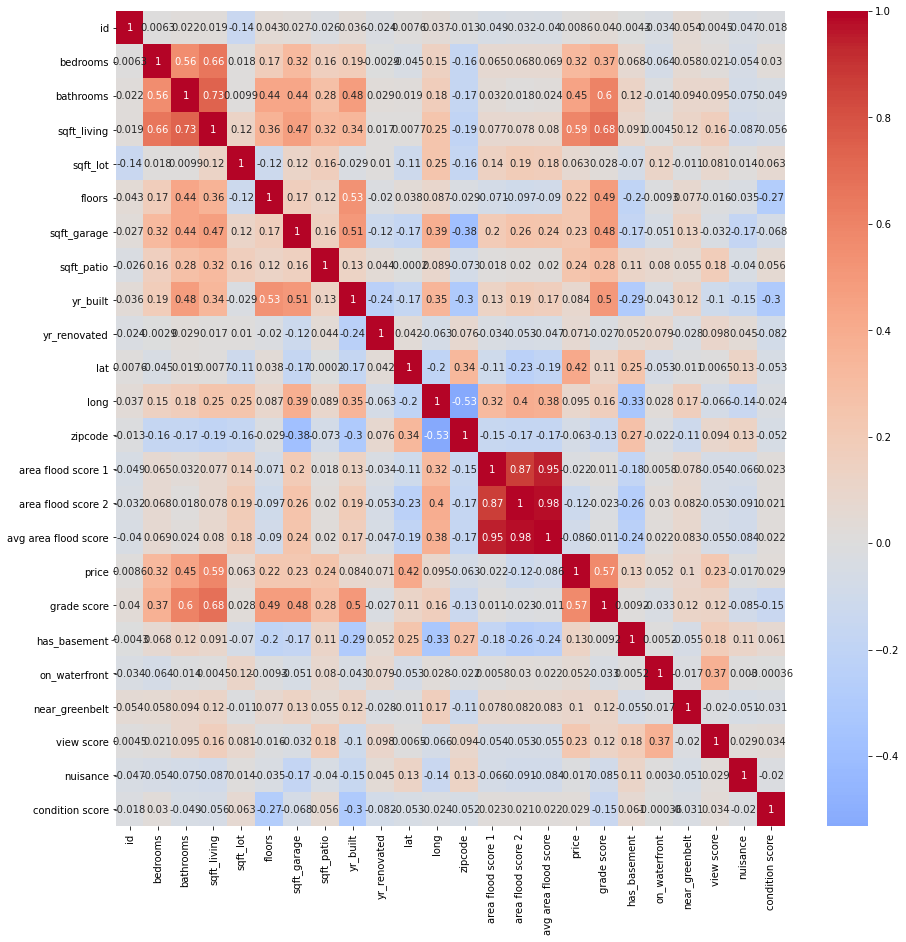

In [12]:
#let's get a new heatmap

new_corr = df.corr()

# Plot heatmap
plt.figure(figsize = (15,15))
sns.heatmap(new_corr, center = 0, annot = True, cmap = 'coolwarm')
plt.show()

In [13]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# https://www.statology.org/how-to-calculate-vif-in-python/

y, X = dmatrices('sqft_living ~ bedrooms+bathrooms', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,15.868828,Intercept
1,1.447613,bedrooms
2,1.447613,bathrooms


In [14]:
# our VIF scores aren't bad (2-5 is moderate). let's try this again for a few other variables

In [15]:
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'heat_source', 'sewer_system', 'sqft_garage', 'sqft_patio',
       'yr_built', 'yr_renovated', 'lat', 'long', 'street address', 'city',
       'zipcode', 'floodzones in zipcode', 'area flood score 1',
       'area flood score 2', 'avg area flood score', 'price', 'grade score',
       'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance', 'condition score'],
      dtype='object')

In [16]:
df.rename(columns={'area flood score 1': 'area_flood_score_max', 'area flood score 2':'area_flood_score_min', 
                   'avg area flood score':'avg_area_flood_score'}, inplace=True)

In [17]:
df.rename(columns={'floodzones in zipcode': 'floodzones_in_zipcode'}, inplace=True)

In [18]:
y, X = dmatrices('area_flood_score_max ~  area_flood_score_min+avg_area_flood_score', data=df, return_type='dataframe')


vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,94.865676,Intercept
1,27.516518,area_flood_score_min
2,27.516518,avg_area_flood_score


In [19]:
# very high VIF scores for our flood data, but should we drop? unsure how to handle
# overall, VIF scores are superior to correlation data, per https://online.stat.psu.edu/stat462/node/180/

In [20]:
#gonna leave them for now. resaving this training data

df.to_csv('cleaned_training_2.csv')

In [21]:
# now that we have a new dataframe, let's open it, do some onehot coding and run some regressions

In [22]:
df_2 = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/cleaned_training_2.csv')

In [23]:
def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [24]:
onehot_df = one_hot_encode(df_2, ['grade score', 'has_basement', 'on_waterfront', 'near_greenbelt', 'view score',
       'nuisance'])
onehot_df.head()

,Unnamed: 0,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,heat_source,sewer_system,...,grade score_11,grade score_12,has_basement_1,on_waterfront_1,near_greenbelt_1,view score_1,view score_2,view score_3,view score_4,nuisance_1
0,0,3873900250,2021-07-19,3,1.5,1420,10364,1.0,Gas,PRIVATE,...,0,0,0,0,0,0,0,0,0,0
1,1,627300085,2021-12-07,4,3.0,4100,10400,1.0,Gas,PUBLIC,...,0,0,1,0,0,0,0,0,1,0
2,2,8682230800,2021-09-27,2,2.5,2170,6853,1.0,Gas,PUBLIC,...,0,0,0,0,0,0,0,0,0,0
3,3,3629980690,2021-06-10,4,2.5,2310,3830,2.0,Gas,PUBLIC,...,0,0,0,0,0,0,0,0,0,0
4,4,8651430370,2022-04-29,4,1.0,1240,5200,1.0,Gas,PUBLIC,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# somehow didn't drop sewer and heat source in this new csv? dropping now

df_2.drop(columns=['sewer_system', 'heat_source'], axis=1, inplace=True)

In [26]:
df_2.head()

,Unnamed: 0,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,...,area_flood_score_min,avg_area_flood_score,price,grade score,has_basement,on_waterfront,near_greenbelt,view score,nuisance,condition score
0,0,3873900250,2021-07-19,3,1.5,1420,10364,1.0,380,0,...,2.200000,2.30,460000.0,7,0,0,0,0,0,4
1,1,627300085,2021-12-07,4,3.0,4100,10400,1.0,0,460,...,2.200000,2.30,2205000.0,8,1,0,0,4,0,4
2,2,8682230800,2021-09-27,2,2.5,2170,6853,1.0,580,200,...,2.333333,2.50,1500000.0,8,0,0,0,0,0,3
3,3,3629980690,2021-06-10,4,2.5,2310,3830,2.0,470,50,...,2.000000,2.25,1250000.0,9,0,0,0,0,0,3
4,4,8651430370,2022-04-29,4,1.0,1240,5200,1.0,0,80,...,2.333333,2.50,500000.0,6,0,0,0,0,0,5


In [27]:
# finally, let's get into models!

In [28]:
X_train = np.array(df_2['sqft_living']).reshape(-1, 1)
y_train = df_2['price']
X_train

array([[1420],
       [4100],
       [2170],
       ...,
       [1350],
       [2280],
       [2310]])

In [29]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     9963.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        13:42:53   Log-Likelihood:            -2.7039e+05
No. Observations:               18805   AIC:                         5.408e+05
Df Residuals:                   18803   BIC:                         5.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.912e+05   8555.227     22.344      0.000    1.74e+05    2.08e+05
x1           398.6513      3.994     99.814      0.000     390.823     406.480
==============================================================================
Omnibus:                     2978.417   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6635.753
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                       5.239   Cond. No.                     5.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# our R2 is very low. let's try another model

In [31]:
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

# Evaluate using rmse
scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)
# ValueError: Expected 2D array, got 1D array instead:
#array=[1420 4100 2170 ... 1350 2280 2310].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [32]:
rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())


array([430212.88732604, 413830.22610237, 413826.78355632, 428375.49507535,
       399822.19911496, 429580.77429805, 442918.94344847, 426369.32100764,
       439013.77179312, 423010.93696681])

424696.1338689125

12105.619877439343

In [33]:
# mean error is 424k! std is 12105. that's pretty large. we can imagine this would happen because
# king county is so large and has a lot of variation. small places in seattle would sell for a lot more
# than large places in less-desirable areas. let's add more features

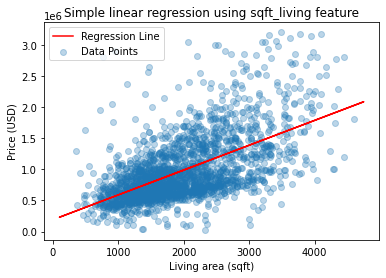

In [34]:
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'red', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_living feature')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()

In [41]:
#where did this unnamed column come from? let's get rid of it
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [42]:
# so size isn't super-relevant for king county. let's look at area. we need to drop all area info in 
# order to get our base model. let's also remove object data, since the model can't handle it
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date'], axis=1)
y_train = df_2['price']



In [38]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     924.0
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        13:43:43   Log-Likelihood:            -2.6794e+05
No. Observations:               18805   AIC:                         5.359e+05
Df Residuals:                   18784   BIC:                         5.361e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.205e+06 

In [ ]:
#well, our model isn't very predictive. probably due to the multicollinearity with the flood data? look at "cond. no."

In [ ]:
#let's try removing it

In [39]:
df_2.columns

Index(['Unnamed: 0', 'id', 'date', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'street address', 'city', 'zipcode',
       'floodzones_in_zipcode', 'area_flood_score_max', 'area_flood_score_min',
       'avg_area_flood_score', 'price', 'grade score', 'has_basement',
       'on_waterfront', 'near_greenbelt', 'view score', 'nuisance',
       'condition score'],
      dtype='object')

In [43]:
X_train = df_2.drop(['area_flood_score_min','area_flood_score_max', 'avg_area_flood_score','price','lat', 'long', 'zipcode', 'street address', 'city', 'floodzones_in_zipcode','date', ], axis=1)
y_train = df_2['price']

In [44]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     994.2
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        13:50:48   Log-Likelihood:            -2.6835e+05
No. Observations:               18805   AIC:                         5.367e+05
Df Residuals:                   18787   BIC:                         5.369e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.838e+06    2.7e+05     

In [46]:
# welp ,that made it worse!! let's leave those in and re-categorize our object data and use it
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18805 entries, 0 to 18804
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     18805 non-null  int64  
 1   date                   18805 non-null  object 
 2   bedrooms               18805 non-null  int64  
 3   bathrooms              18805 non-null  float64
 4   sqft_living            18805 non-null  int64  
 5   sqft_lot               18805 non-null  int64  
 6   floors                 18805 non-null  float64
 7   sqft_garage            18805 non-null  int64  
 8   sqft_patio             18805 non-null  int64  
 9   yr_built               18805 non-null  int64  
 10  yr_renovated           18805 non-null  int64  
 11  lat                    18805 non-null  float64
 12  long                   18805 non-null  float64
 13  street address         18805 non-null  object 
 14  city                   18805 non-null  object 
 15  zi

In [52]:
df_2['street address'] = df_2['street address'].astype('category')
df_2['city'] = df_2['city'].astype('category')
df_2['floodzones_in_zipcode'] = df_2['floodzones_in_zipcode'].astype('category')



In [53]:
X_train = df_2.drop(['price','lat', 'long', 'zipcode', 'date', ], axis=1)
y_train = df_2['price']

In [55]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

print(results.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const                     float64
id                          int64
bedrooms                    int64
bathrooms                 float64
sqft_living                 int64
sqft_lot                    int64
floors                    float64
sqft_garage                 int64
sqft_patio                  int64
yr_built                    int64
yr_renovated                int64
street address           category
city                     category
floodzones_in_zipcode    category
area_flood_score_max      float64
area_flood_score_min      float64
avg_area_flood_score      float64
grade score                 int64
has_basement                int64
on_waterfront               int64
near_greenbelt              int64
view score                  int64
nuisance                    int64
condition score             int64
dtype: object. The data was
0         460000.0
1        2205000.0
2        1500000.0
3        1250000.0
4         500000.0
           ...    
18800     675000.0
18801     815000.0
18802     790000.0
18803     560000.0
18804     716000.0
Name: price, Length: 18805, dtype: float64
and
        const          id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0        1.0  3873900250         3        1.5         1420     10364     1.0   
1        1.0   627300085         4        3.0         4100     10400     1.0   
2        1.0  8682230800         2        2.5         2170      6853     1.0   
3        1.0  3629980690         4        2.5         2310      3830     2.0   
4        1.0  8651430370         4        1.0         1240      5200     1.0   
...      ...         ...       ...        ...          ...       ...     ...   
18800    1.0  1922069156         3        3.0         2020     43560     2.0   
18801    1.0  1085622660         4        2.5         1955      4465     2.0   
18802    1.0  2226700035         3        1.0         1350      9509     1.0   
18803    1.0  1312100140         5        2.5         2280      8136     1.0   
18804    1.0   305500010         3        2.5         2310      4532     2.0   

       sqft_garage  sqft_patio  yr_built  ...  area_flood_score_max  \
0              380           0      1961  ...              2.400000   
1                0         460      1958  ...              2.400000   
2              580         200      2004  ...              2.666667   
3              470          50      2006  ...              2.500000   
4                0          80      1969  ...              2.666667   
...            ...         ...       ...  ...                   ...   
18800          530          60      1978  ...              2.666667   
18801          534         150      2013  ...              2.571429   
18802          220           0      1955  ...              2.250000   
18803            0         170      1967  ...              2.400000   
18804          520         190      2004  ...              2.428571   

      area_flood_score_min avg_area_flood_score grade score  has_basement  \
0                 2.200000             2.300000           7             0   
1                 2.200000             2.300000           8             1   
2                 2.333333             2.500000           8             0   
3                 2.000000             2.250000           9             0   
4                 2.333333             2.500000           6             0   
...                    ...                  ...         ...           ...   
18800             2.333333             2.500000           8             0   
18801             2.428571             2.500000           8             0   
18802             2.000000             2.125000           7             0   
18803             2.200000             2.300000           7             1   
18804             2.285714             2.357143           8             0   

       on_waterfront  near_greenbelt  view score  nuisance  condition score  
0                  0               0           0         0                4  
1                  0               0           4         0                4  
2                  0               0           0         0                3  
3                  0               0           0         0                3  
4                  0               0           0         0                5  
...              ...             ...         ...       ...              ...  
18800              0               0           0         0                3  
18801              0               0           0         0                3  
18802              0               0           0         0                3  
18803              0               0           0         0                5  
18804              0               0           0         0                3  

[18805 rows x 24 columns]
before. After,
[ 460000. 2205000. 1500000. ...  790000.  560000.  716000.]
[[1.0 3873900250 3 ... 0 0 4]
 [1.0 627300085 4 ... 4 0 4]
 [1.0 8682230800 2 ... 0 0 3]
 ...
 [1.0 2226700035 3 ... 0 0 3]
 [1.0 1312100140 5 ... 0 0 5]
 [1.0 305500010 3 ... 0 0 3]].